In [191]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import warnings
warnings.filterwarnings('ignore')
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [200]:
#preprocessing of CSV 
data = []
file_list = ['groups_02.csv','groups_04.csv','groups_05.csv', 'groups_IL.csv']
#file_list = ['groups_05.csv']
for file_path in file_list:
    file1 = pd.read_csv(file_path)
    t = file1.drop_duplicates(['meetup_0_description'], keep='last')
    text_list = t['meetup_0_description'].tolist()
    text_list = list(map(str, text_list))
    for text in text_list:
        data.append(text)

In [258]:
meetup_words = ['<p>','<\p>','<br>','http','idea','meeting','need','organization','member','club','group', 'join','meetup','right','idea','join','community','make','social','discuss','local','chapter',
                    'people','country','br','www','span','event','nyyrc','www','facebook','people','href','com','facebook','topic','human','justice','discus','important','_','n•','meet','welcome','event','get','bring','day','join','go','https',
                'nbsp','medium','ideas','style','-PRON-','span','font-size','color','email','small','others','org','state','level']
from nltk.corpus import stopwords
states = ['alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 'delaware', 'florida','span',
            'georgia', 'hawaii', 'idaho', 'illinois', 'indiana'
            , 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota',
            'mississippi', 'missouri','montana', 'nebraska', 'nevada', 'new', 'hampshire', 'new', 'jersey', 'new', 'mexico', 'new', 'york', 'nyc',
            'north carolina', 'north dakota', 'ohio',
            'oklahoma', 'oregon', 'pennsylvania', 'rhode', 'island', 'south', 'carolina', 'south', 'dakota', 'tennessee',
            'texas', 'utah', 'vermont', 'virginia',
            'washington', 'dc', 'west', 'Virginia', 'wisconsin', 'wyoming', 'philadelphia', 'brooklyn', 'america', 'pittsburgh']

stop_words = stopwords.words('english')
stop_words.extend(meetup_words)
stop_words.extend(states)

In [259]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [260]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'alternative', 'banking', 'working', 'group', 'of', 'occupy', 'meets', 'every', 'sunday', 'from', 'pm', 'at', 'columbia', 'university', 'in', 'room', 'of', 'the', 'international', 'affairs', 'building', 'at', 'the', 'corner', 'of', 'th', 'and', 'amsterdam', 'avenue', 'we', 'typically', 'get', 'about', 'people', 'most', 'of', 'whom', 'are', 'on', 'our', 'mail', 'list', 'not', 'meetup', 'we', 'are', 'open', 'to', 'everyone', 'if', 'you', 'are', 'press', 'please', 'identify', 'yourself', 'before', 'the', 'meeting', 'begins', 'also', 'we', 'don', 'allow', 'any', 'recording', 'devices', 'at', 'the', 'meetings', 'and', 'if', 'you', 'want', 'to', 'quote', 'someone', 'you', 'need', 'their', 'explicit', 'permission', 'for', 'each', 'quote', 'to', 'learn', 'more', 'about', 'us', 'see', 'our', 'href', 'http', 'altbanking', 'net', 'web', 'site', 'we', 'typically', 'discuss', 'articles', 'posted', 'on', 'nbsp', 'the', 'href', 'http', 'altbanking', 'net', 'news', 'page', 'we', 'usually', 's

In [261]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
def remove_words(data):
    data_Clean = []
    for word in data:
        if (len(word) > 3) and (len(word) < 20):
            data_Clean.append(word)
    return  data_Clean
            

In [262]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [263]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words, stop_words)


In [264]:
data_words_no = []
for d in data_words_nostops:
    data_words_no.append(remove_words(d))
# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_nostops[0])
import en_core_web_sm
nlp = en_core_web_sm.load()
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

['alternative', 'banking', 'working', 'occupy', 'meets', 'every', 'sunday', 'pm', 'columbia', 'university', 'room', 'international', 'affairs', 'building', 'corner', 'th', 'amsterdam', 'avenue', 'typically', 'mail', 'list', 'open', 'everyone', 'press', 'please', 'identify', 'begins', 'also', 'allow', 'recording', 'devices', 'meetings', 'want', 'quote', 'someone', 'explicit', 'permission', 'quote', 'learn', 'us', 'see', 'altbanking', 'net', 'web', 'site', 'typically', 'articles', 'posted', 'altbanking', 'net', 'news', 'page', 'usually', 'send', 'topics', 'saturday', 'ask', 'topics', 'list', 'please', 'alt', 'banking', 'ows', 'gmail', 'request', 'added', 'list', 'alt', 'banking', 'format', 'meetings', 'follows', 'ol', 'list', 'topics', 'briefly', 'give', 'vote', 'topics', 'see', 'wants', 'top', 'topics', 'chosen', 'engaging', 'discussions', 'topics', 'ol', 'good', 'speakers', 'schedule', 'regular']
[['alternative', 'banking', 'work', 'group', 'occupy', 'meet', 'sunday', 'pm', 'columbia',

In [265]:
data_words_nostops[0]

['alternative',
 'banking',
 'working',
 'occupy',
 'meets',
 'every',
 'sunday',
 'pm',
 'columbia',
 'university',
 'room',
 'international',
 'affairs',
 'building',
 'corner',
 'th',
 'amsterdam',
 'avenue',
 'typically',
 'mail',
 'list',
 'open',
 'everyone',
 'press',
 'please',
 'identify',
 'begins',
 'also',
 'allow',
 'recording',
 'devices',
 'meetings',
 'want',
 'quote',
 'someone',
 'explicit',
 'permission',
 'quote',
 'learn',
 'us',
 'see',
 'altbanking',
 'net',
 'web',
 'site',
 'typically',
 'articles',
 'posted',
 'altbanking',
 'net',
 'news',
 'page',
 'usually',
 'send',
 'topics',
 'saturday',
 'ask',
 'topics',
 'list',
 'please',
 'alt',
 'banking',
 'ows',
 'gmail',
 'request',
 'added',
 'list',
 'alt',
 'banking',
 'format',
 'meetings',
 'follows',
 'ol',
 'list',
 'topics',
 'briefly',
 'give',
 'vote',
 'topics',
 'see',
 'wants',
 'top',
 'topics',
 'chosen',
 'engaging',
 'discussions',
 'topics',
 'ol',
 'good',
 'speakers',
 'schedule',
 'regular']

In [266]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 7), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 3), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 3), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 4), (46, 1), (47, 1), (48, 4), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 6), (82, 2), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1)]]


In [267]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [268]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"woman" + 0.034*"democratic" + 0.021*"county" + 0.014*"cannabis" + '
  '0.014*"voter" + 0.013*"vote" + 0.009*"district" + 0.008*"committee" + '
  '0.007*"part" + 0.007*"illinois"'),
 (1,
  '0.032*"government" + 0.026*"freedom" + 0.023*"-PRON-" + 0.023*"american" + '
  '0.021*"liberty" + 0.021*"state" + 0.019*"party" + 0.017*"constitution" + '
  '0.016*"america" + 0.013*"right"'),
 (2,
  '0.024*"cry" + 0.019*"feminist" + 0.014*"trump" + 0.012*"paul" + '
  '0.012*"west" + 0.012*"illinois" + 0.011*"diego" + 0.010*"side" + '
  '0.010*"india" + 0.010*"science"'),
 (3,
  '0.072*"com" + 0.068*"www" + 0.067*"http" + 0.061*"href" + 0.039*"org" + '
  '0.035*"https" + 0.035*"nbsp" + 0.019*"facebook" + 0.019*"class" + '
  '0.013*"youtube"'),
 (4,
  '0.177*"span" + 0.068*"strong" + 0.032*"style" + 0.020*"li" + 0.015*"color" '
  '+ 0.013*"size" + 0.013*"medium" + 0.013*"watch" + 0.012*"font" + '
  '0.009*"text"'),
 (5,
  '0.134*"nbsp" + 0.024*"firearm" + 0.012*"gun" + 0.008*"amp" + '
 

In [210]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.15173033493

Coherence Score:  0.395110230414


In [211]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      32.491156        1       1 -0.156050 -0.000462
2      25.368223        1       2 -0.139942 -0.034500
4      21.958590        1       3 -0.064188 -0.108298
3      11.682353        1       4  0.287789 -0.103168
0       8.499678        1       5  0.072391  0.246428, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
348   Default   519.000000          www   519.000000  30.0000  30.0000
21    Default   565.000000          com   565.000000  29.0000  29.0000
40    Default   510.000000         http   510.000000  28.0000  28.0000
39    Default   465.000000         href   465.000000  27.0000  27.0000
531   Default   899.000000         span   899.000000  26.0000  26.0000
52    Default  1246.000000         nbsp  1246.000000  25.0000  25.0000
314   Default   306.000000          org   306.000000  24.0000  24.0000
364   Default   268.000000        https   268.000000  23.0000  23.0000
121   Default   986.000000           br   986.000000  22.0000  22.0000
150   Default   347.000000       strong   347.000000  21.0000  21.0000
14    Default  3679.000000           be  3679.000000  20.0000  20.0000
209   Default   298.000000        party   298.000000  19.0000  19.0000
472   Default   156.000000     facebook   156.000000  18.0000  18.0000
38    Default   761.000000         have   761.000000  17.0000  17.0000
205   Default   303.000000        event   303.000000  16.0000  16.0000
1687  Default   162.000000        style   162.000000  15.0000  15.0000
712   Default   259.000000        state   259.000000  14.0000  14.0000
449   Default   145.000000        class   145.000000  13.0000  13.0000
189   Default   534.000000        other   534.000000  12.0000  12.0000
545   Default   101.000000      youtube   101.000000  11.0000  11.0000
88    Default   289.000000         what   289.000000  10.0000  10.0000
0     Default  2235.000000       -PRON-  2235.000000   9.0000   9.0000
133   Default   210.000000   government   210.000000   8.0000   8.0000
299   Default   274.000000        local   274.000000   7.0000   7.0000
889   Default   224.000000       county   224.000000   6.0000   6.0000
109   Default   343.000000    political   343.000000   5.0000   5.0000
997   Default   162.000000   democratic   162.000000   4.0000   4.0000
208   Default   173.000000  libertarian   173.000000   3.0000   3.0000
148   Default   313.000000        right   313.000000   2.0000   2.0000
155   Default   190.000000        woman   190.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
916    Topic5    14.782655        heart    15.898348   2.3924  -6.1744
1529   Topic5    52.876436        truth    60.620556   2.3285  -4.8998
751    Topic5    19.164289      college    21.731199   2.3394  -5.9148
1323   Topic5    21.639506         cost    25.694935   2.2934  -5.7933
1165   Topic5    25.090199     congress    31.458090   2.2390  -5.6453
217    Topic5    47.487896        trump    96.936070   1.7516  -5.0073
52     Topic5   194.760265         nbsp  1246.299938   0.6090  -3.5960
64     Topic5    28.194660           pm    52.440930   1.8446  -5.5287
155    Topic5    53.541961        woman   190.610137   1.1954  -4.8873
862    Topic5    17.143460      service    26.641615   2.0243  -6.0262
1142   Topic5    27.829586         call    75.526220   1.4668  -5.5417
118    Topic5    64.475808         will   532.034518   0.3547  -4.7015
14     Topic5   143.168426           be  3679.262347  -0.7813  -3.9038
319    Topic5    22.714074       person    58.124167   1.5255  -5.7448
139    Topic5    34.005284          new   164.725766   0.8874  -5.3413
121    Topic5    67.023935           br   986.436924  -0.2239  -4.6628
38     Topic5    59.168230         have   761.068525  -0.0892  -4.7874
399    Topic5    24.425284  i

In [85]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Build LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())
        # Compute Perplexity


    return model_list, coherence_values

In [88]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=6)

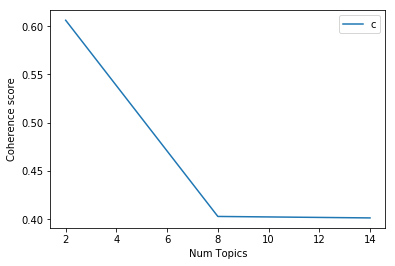

In [89]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()